              precision    recall  f1-score   support

           1       1.00      1.00      1.00       231
           2       1.00      1.00      1.00       258

    accuracy                           1.00       489
   macro avg       1.00      1.00      1.00       489
weighted avg       1.00      1.00      1.00       489



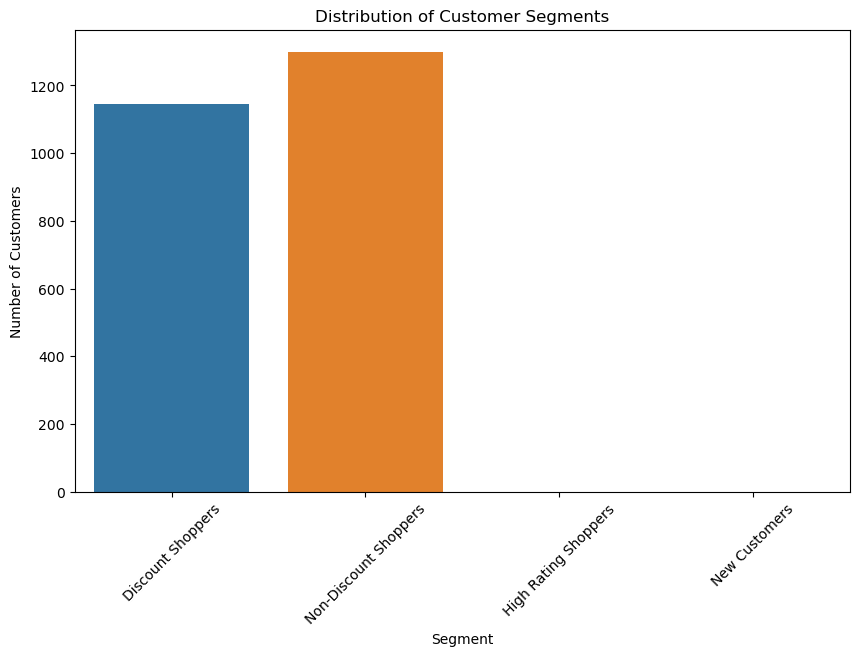

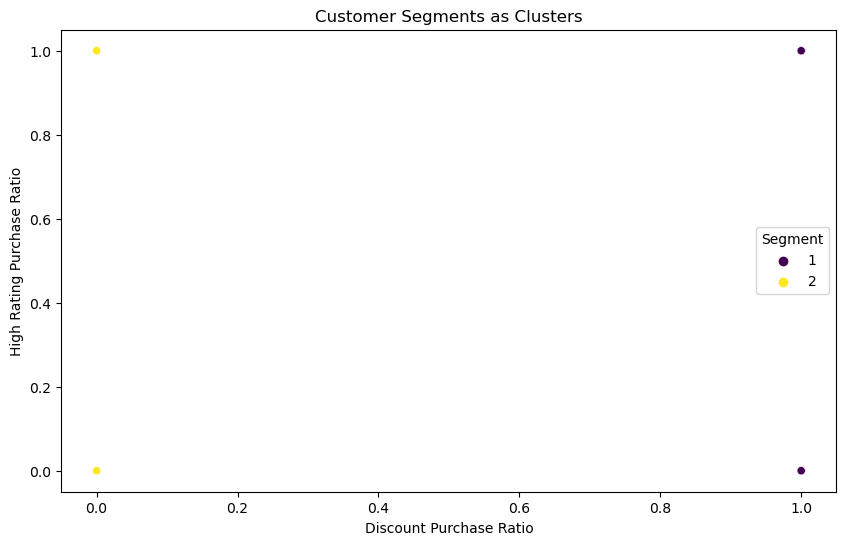

Customer Segment: Customer who do shop more on discount products
Recommended Products:
     Gender Item_Purchased Size      Color    Sku_ID  Review_Rating  \
0      Male         Blouse    L       Gray    SKU_01            3.1   
1      Male        Sweater    L     Maroon    SKU_02            3.1   
2      Male          Jeans    S     Maroon    SKU_03            3.1   
3      Male        Sandals    M     Maroon    SKU_04            3.5   
4      Male         Blouse    M  Turquoise    SKU_05            2.7   
...     ...            ...  ...        ...       ...            ...   
1140   Male          Skirt    M       Blue  SKU_1141            3.1   
1141   Male        Handbag    L      Brown  SKU_1142            3.4   
1142   Male          Boots    L       Gold  SKU_1143            3.8   
1143   Male         Blouse    M     Violet  SKU_1144            3.4   
1144   Male           Coat    M      Peach  SKU_1145            3.2   

     Discount_Applied  
0                 Yes  
1           

c:\Users\sharm\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the actual product table
product_df = pd.read_csv('product_data.csv')

# Ensure 'Discount_Applied' and 'Gender' columns are in the correct format
product_df['Discount_Applied'] = product_df['Discount_Applied'].map({'Yes': 'Yes', 'No': 'No'})
product_df['Gender'] = product_df['Gender'].astype('category')

# Load customer purchase history data
df = pd.read_csv('customer_purchase_data.csv')

# Convert 'Yes'/'No' in 'Discount_Applied' to 1/0
df['Discount_Applied'] = df['Discount_Applied'].map({'Yes': 1, 'No': 0})

# Ensure numeric columns are indeed numeric and handle non-numeric values
numeric_columns = ['Review_Rating', 'Discount_Applied', 'Previous_Purchases', 'Frequency of Purchases']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Feature Engineering
high_rating_threshold = 4

df['Discount_Purchase_Ratio'] = df.groupby('Customer_ID')['Discount_Applied'].transform('sum') / df.groupby('Customer_ID')['Item_Purchased_ID'].transform('count')
df['High_Rating_Purchase_Ratio'] = df.apply(lambda x: 1 if x['Review_Rating'] >= high_rating_threshold else 0, axis=1)
df['High_Rating_Purchase_Ratio'] = df.groupby('Customer_ID')['High_Rating_Purchase_Ratio'].transform('sum') / df.groupby('Customer_ID')['Item_Purchased_ID'].transform('count')
df['Previous_Purchases'] = df.groupby('Customer_ID')['Previous_Purchases'].transform('max')
df['Frequency_of_Purchases'] = df.groupby('Customer_ID')['Frequency of Purchases'].transform('max')

# Define segments
conditions = [
    (df['Discount_Purchase_Ratio'] > 0.5),  # Customer who do shop more on discount products
    (df['Discount_Purchase_Ratio'] == 0),   # Customer who buy non discount products
    (df['High_Rating_Purchase_Ratio'] > 0.7),  # Customer who buys only with the higher ratings
    ((df['Frequency_of_Purchases'] < 2) & (df['Previous_Purchases'] < 5))  # Customer who are new customers
]

choices = [1, 2, 3, 4]

df['Segment'] = np.select(conditions, choices, default=0)

# Train a model to predict the segment
features = ['Discount_Purchase_Ratio', 'High_Rating_Purchase_Ratio', 'Frequency_of_Purchases', 'Previous_Purchases']
X = df[features]
y = df['Segment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Function to segment a single customer using the trained model
def segment_customer(customer_id):
    customer_data = df.loc[df['Customer_ID'] == customer_id, features]
    
    if customer_data.empty:
        print("Customer ID not found.")
        return None
    
    features_data = customer_data.iloc[0].values.reshape(1, -1)
    segment = model.predict(features_data)[0]
    return segment

# Function to recommend products based on the segment and customer gender
def recommend_products(segment, gender):
    if segment == 1:
        recommendations = product_df.loc[(product_df['Discount_Applied'] == 'Yes') & ((product_df['Gender'] == gender) | (product_df['Gender'] == 'Unisex'))]
    elif segment == 2:
        recommendations = product_df.loc[(product_df['Discount_Applied'] == 'No') & ((product_df['Gender'] == gender) | (product_df['Gender'] == 'Unisex'))]
    elif segment == 3:
        recommendations = product_df.loc[(product_df['Review_Rating'] >= high_rating_threshold) & ((product_df['Gender'] == gender) | (product_df['Gender'] == 'Unisex'))]
    elif segment == 4:
        recommendations = product_df.loc[(product_df['Gender'] == gender) | (product_df['Gender'] == 'Unisex')]
    else:
        recommendations = product_df.loc[(product_df['Gender'] == gender) | (product_df['Gender'] == 'Unisex')]
    
    return recommendations

# Visualize the distribution of segments
def visualize_segments():
    segment_names = {
        1: "Discount Shoppers",
        2: "Non-Discount Shoppers",
        3: "High Rating Shoppers",
        4: "New Customers"
    }
    
    df['Segment_Name'] = df['Segment'].map(segment_names)
    
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Segment_Name', data=df, order=segment_names.values())
    plt.title('Distribution of Customer Segments')
    plt.xlabel('Segment')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.show()

# Visualize segments as clusters
def visualize_clusters():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Discount_Purchase_Ratio', y='High_Rating_Purchase_Ratio', hue='Segment', palette='viridis')
    plt.title('Customer Segments as Clusters')
    plt.xlabel('Discount Purchase Ratio')
    plt.ylabel('High Rating Purchase Ratio')
    plt.show()

# Prompt user for Customer_ID and produce recommendations
def main():
    visualize_segments()
    visualize_clusters()
    
    customer_id = int(input("Enter Customer ID: "))
    customer_data = df.loc[df['Customer_ID'] == customer_id]
    if customer_data.empty:
        print("Customer ID not found.")
        return
    
    customer_gender = customer_data['Gender'].iloc[0]
    customer_segment = segment_customer(customer_id)
    if customer_segment is None:
        return
    
    recommended_products = recommend_products(customer_segment, customer_gender)
    
    segment_names = {
        1: "Customer who do shop more on discount products",
        2: "Customer who buy non discount products",
        3: "Customer who buys only with the higher ratings",
        4: "Customer who are new customers"
    }
    
    print(f"Customer Segment: {segment_names[customer_segment]}")
    print("Recommended Products:")
    print(recommended_products)

if __name__ == "__main__":
    main()
